<a href="https://colab.research.google.com/github/bryanMontoya/mlTalleres/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Detección automática de drones a través de audio con NN**

# **Introducción**
Los drones son aeronaves no tripuladas controladas remotamente que se han diversificado al público en general en los últimos años. La popularidad de esta tecnología ha incrementado debido a sus precios asequibles,  tamaños más compactos, y la fácil operación para cualquiera que los quiera usar (Al-Emadi et al., 2019).

Estos vehículos han sido usados comúnmente en tareas militares, sin embargo, debido al desarrollo de esta tecnología y su diversificación, hoy los drones se usan para salvar vidas, entregar suministros médicos, en ámbitos como la vigilancia, el cine, la construcción de estructuras, la agricultura y mucho más (Alwateer, Loke, & Niroshinie, 2019). Sin embargo, no siempre se le da el uso debido a esta tecnología y algunas personas la ocupan para hacer daño a su entorno.

Aunque existen tantos usos positivos de los drones que dan apoyo a labores humanas, desafortunadamente también se han utilizado para actos delictivos. Uno de los casos que han sido documentados es el de la cárcel Peñas Blancas ubicada en el departamento de Quindío, Colombia, en donde quedó registrado el momento en el que se hizo uso de un pequeño dron para ingresar un paquete con armas, estupefacientes y dispositivos móviles dentro de este lugar. Las autoridades no estaban preparadas para un evento de este tipo y sólo les quedó hacer una investigación de qué personas pudieron estar tras el control de este dispositivo (El Tiempo, 2021).

Así como en el caso anterior, se pueden encontrar muchos otros casos donde se evidencia el mal uso de esta tecnología. Debido a esto, se puede considerar importante la implementación de nuevas herramientas tecnológicas para evitar o predecir eventos futuros que puedan dañar la integridad de las personas, espacios públicos y privados, entre otros.


Para dar solución al problema planteado, se hace uso del dataset construido por Sara Al Emadi, el cual se puede encontrar en el siguiente link: https://github.com/saraalemadi/DroneAudioDataset

Este dataset consiste de sonidos de dos tipos de drones, grabados por un iphone, de igual manera contiene sonidos aleatorios como animales, personas, etc. Este dataset se usará para entrenar los modelos con los que se planee dar solución al problema.





# Sección de importación de librerías.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA

import tensorflow as tf
from random import randint

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model #Crear modelo de NN
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate
# keras imports for the dataset and building our neural network
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils

# to calculate accuracy
from sklearn.metrics import accuracy_score

# Preprocesamiento

Se procede a realizar el preprocesamiento de los datos. Para esto, se leen los diferentes audios de los cuales se compone el dataset, posteriormente se realiza un espectrograma de cada audio y se guarda. A continuación se muestra uno de los espectrogramas generados.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_im = 'drive/Shareddrives/Final/DroneAudioDataset/Binary_Drone_Audio/Datos_mezclados/'
imagenes = listdir(path_im)
len(imagenes)

2799

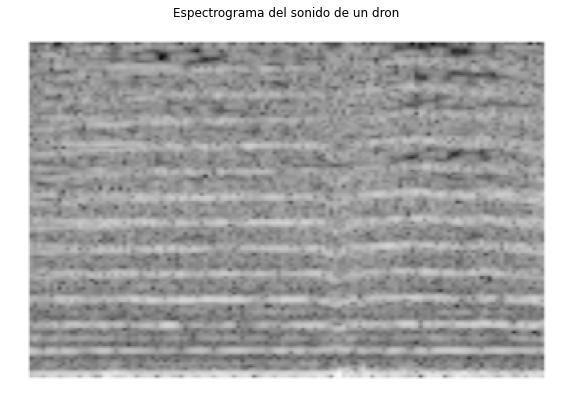

In [ ]:
image = cv2.imread(path_im + "Membo_0_006-membo_002_Y.png")
plt.figure(figsize = (10,10));
plt.imshow(image);
plt.title("Espectrograma del sonido de un dron")
plt.axis("off");

Luego de tener los espectrogramas, se procede a leer cada imágen, llevarla a un formato de numpy y estandarizarla. Luego se genera una lista de etiquetas dependiendo si el título de la imágen corresponde a un dron $1$ o a un sonido desconocido $0$.

In [ ]:
imagesDataset = []
labels = []

for im in imagenes:
  image = cv2.imread(path_im + im)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
  image = np.array(image)
  image = image.astype('float32')
  image/=255
  imagesDataset.append(image)
  if (im[-5] == "Y"):
    labels.append(1)
  else:
    labels.append(0)      

imagesDataset = np.array(imagesDataset)
labels = np.array(labels)

A continuación se pueden observar las etiquetas generadas para cada imágen.

In [ ]:
print(labels[1000:1703])

[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 

Luego de tener las imágenes en un formato matricial y de haber generado las etiquetas, se procede a dividir los datos entre entrenamiento y test, para esto se hace uso de el train_test_split.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(imagesDataset, labels, test_size = 0.2, random_state = 4)              
print(len(X_train))
print(len(X_test))

2239
560


A continuación se pueden apreciar algunas de las imágenes de espectrogarmas generados y su respectiva etiqueta:

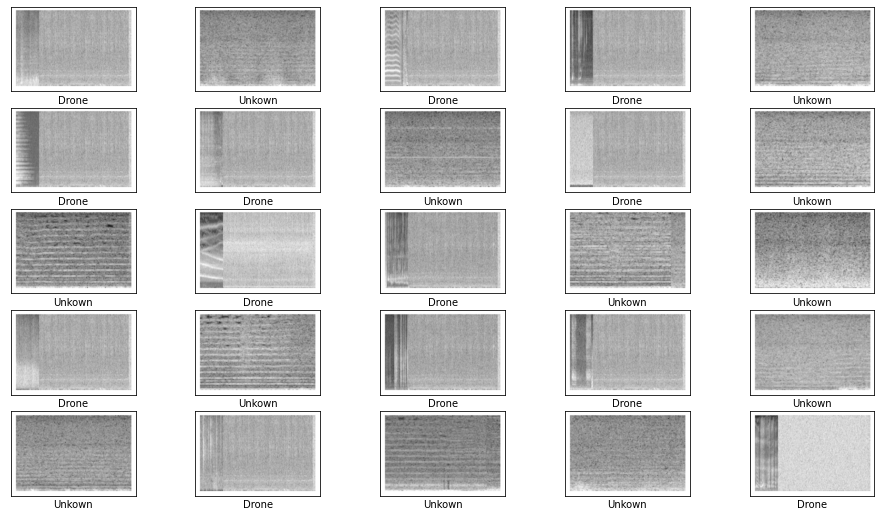

In [ ]:
className = ['Drone', 'Unkown']
plt.figure(figsize = (16, 9))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  n = randint(0, X_train.shape[0] - 1)
  plt.imshow(X_train[n], cmap = plt.cm.binary)
  plt.xlabel(className[y_train[n]])

# **Creación del modelo**

Se procede a crear un modelo de red neuronal NN. Esta tiene una capa de entrada la cual se deben a las dimensiones de imágen de cada espectrograma las cuales se componen de 231 filas, 342 columnas y 3 capas. Tambien posee capaz intermedias con función de activación relu con 128, 64, 32, y 16 neuronas respectivamente.

Por último, cuenta con una capa de salida de dos neuronas, una para cada clase, con una función de activación softmax.

In [ ]:
num_classes = 2
img_rows, img_columns = 231, 342
num_channeels = 3
input_shape = (img_rows, img_columns, num_channeels)

Se dividen datos de test entre datos de validación y datos de test.

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 4)              

Se procede a crear el modelo, compilarlo y entrenarlo.

In [ ]:
model = tf.keras.models.Sequential()
model.add(Flatten(input_shape = (231, 342, 3))) #Capa de entrada.
model.add(Dense(128, activation = 'relu')) #Capas intermedias.
model.add(Dense(64, activation = 'relu')) #Capas intermedias.
model.add(Dense(32, activation = 'relu')) #Capas intermedias.
model.add(Dense(16, activation = 'relu')) #Capas intermedias.
model.add(Dense(2, activation = 'softmax')) #Capas de salida.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 237006)            0         
                                                                 
 dense (Dense)               (None, 128)               30336896  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 30,347,794
Trainable params: 30,347,794
No

Visualización del modelo creado.

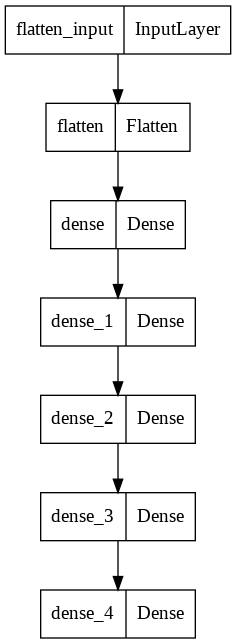

In [ ]:
plot_model(model)

Se compila el modelo.

In [ ]:
model.compile(tf.keras.optimizers.SGD(learning_rate = 0.01), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

Se entrena el modelo y se valida con los datos de validación.

In [ ]:
model.fit(X_train, y_train, epochs = 10, verbose = 1, validation_data = (X_val, y_val))

Epoch 1/10
70/70 [==============================] - 3s 35ms/step - loss: 1.5058 - accuracy: 0.5007 - val_loss: 0.7017 - val_accuracy: 0.5036
Epoch 2/10
70/70 [==============================] - 2s 30ms/step - loss: 0.6943 - accuracy: 0.5141 - val_loss: 0.6954 - val_accuracy: 0.5036
Epoch 3/10
70/70 [==============================] - 2s 30ms/step - loss: 0.6899 - accuracy: 0.5480 - val_loss: 0.6939 - val_accuracy: 0.5036
Epoch 4/10
70/70 [==============================] - 2s 29ms/step - loss: 0.6914 - accuracy: 0.5257 - val_loss: 0.6961 - val_accuracy: 0.5036
Epoch 5/10
70/70 [==============================] - 2s 29ms/step - loss: 0.6893 - accuracy: 0.5351 - val_loss: 0.6909 - val_accuracy: 0.5036
Epoch 6/10
70/70 [==============================] - 2s 29ms/step - loss: 0.6899 - accuracy: 0.5297 - val_loss: 0.6927 - val_accuracy: 0.5036
Epoch 7/10
70/70 [==============================] - 2s 28ms/step - loss: 0.6841 - accuracy: 0.5520 - val_loss: 0.6786 - val_accuracy: 0.5036
Epoch 8/10
70

# **Métricas de desempeño**

Se evalúan nuevos datos y se realizan las precciones con el modelo.

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
predicted_classes = utils.label_with_highest_prob(y_pred)

Confusion matrix


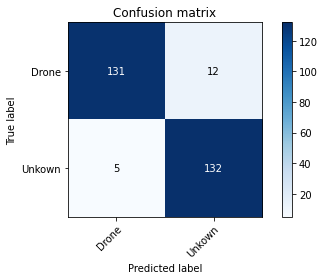

In [ ]:
utils.plot_confusion_matrix(y_pred = predicted_classes, y_true = y_test, classes=np.array(className));

# **Conclusiones y recomendaciones**



*   Las redes neuronales son un sistema complejo que a pesar de exigir gran costo computacional, su desempeño puede llegar a ser mucho mejor que otros modelos de clasificación. Sin embargo, se vuelve difícil encontrar una estructura que se acomode perfectamente a un problema.
*   El aprendizaje automático se ha convertido en una herramienta valiosa para la solución de problemas del mundo real que involucren clasificación o identificación. La posibilidad actual de usar aceleradores como las GPU hacen posible la implementación de soluciones que involucren modelos de inteligencia artificial.
* Se pudo observar que uno de los métodos de clasificación de audio se hace a través de un preprocesamiento de los datos que involucre la generación de espectrogramas para cada audio. Posteriormente estos espectrogramas son usados en modelos como si se trataran de modelos de clasificación de imágenes.
* La selección de un modelo correcto para la solución del problema puede influir de gran manera en el desempeño de la solución. Para este caso el uso de una red neuronal mostró buenos resultados tal como se puede apreciar en la matriz de confusión donde un gran porcentaje de los datos fueron clasificados correctamente.
* Como trabajos futuros se recomienda implementar modelos más complejos de deep learning como redes neuronales convolucionales CNN, redes recurrentes, AlexNet entre otras. De igual manera se recomienda la implementación de modelos de machine learning para los cuales se extraigan características descriptivas de cada uno de los audios.



# **Referencias**



*   Al-Emadi, S., Al-Ali, A., & Al-Ali, A. (2019). Audio-Based Drone Detection and Identification Using Deep Learning Techniques with Dataset Enhancement through Generative Adversarial Networks. Sensors, 21(15), 4953. https://doi.org/10.3390/s21154953

*   M. Alwateer, S. W. Loke and N. Fernando, "Enabling Drone Services: Drone Crowdsourcing and Drone Scripting," in IEEE Access, vol. 7, pp. 110035-110049, 2019, doi: 10.1109/ACCESS.2019.2933234.

*   Tiempo, E. L. (2021, 2 marzo). Video: usan drones para entrar armas y drogas a cárcel del Quindío. El Tiempo. https://www.eltiempo.com/colombia/otras-ciudades/con-drones-
ingresan-armas-estupefacientes-y-hasta-celulares-a-carcel-del-quindio-570495


